<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/hands-on-generative-ai-with-transformers-and-diffusion-models/04_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture

!pip install genaibook
!pip install datasets

In [13]:
import datasets
import diffusers
import huggingface_hub

import torch
from torchvision import transforms

from diffusers import DDPMPipeline
from diffusers import DDPMScheduler

from datasets import load_dataset

from genaibook.core import get_device
from genaibook.core import plot_noise_and_denoise
from genaibook.core import show_images

import pandas as pd
import numpy as np

In [3]:
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

In [4]:
device = get_device()

## Iterative Refinement

In [ ]:
# Load the pipeline
image_pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]

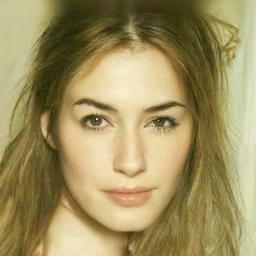

In [ ]:
# Sample an image
image = image_pipeline().images[0]
image

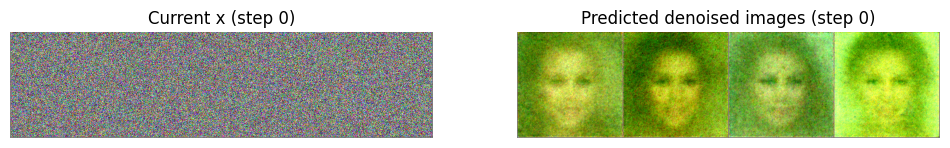

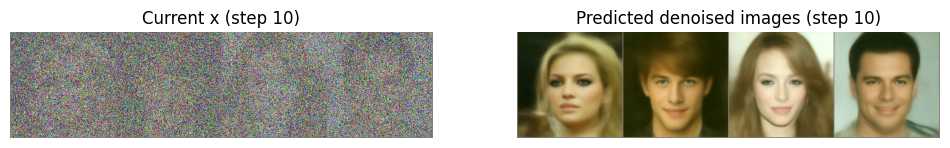

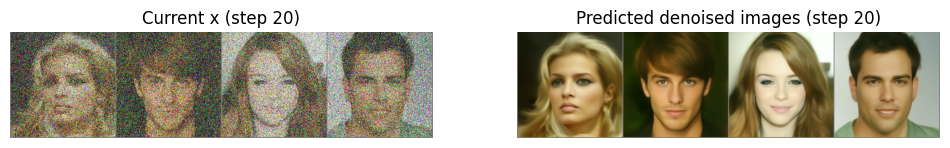

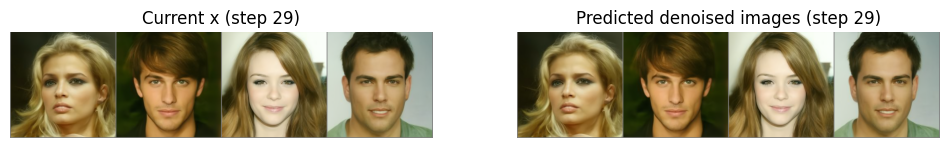

In [ ]:
# The random starting point is a batch of 4 images
# Each image is 3-channel (RGB) 256x256 pixel image
image = torch.randn(4, 3, 256, 256).to(device)

# Set the specific number of diffusion steps
image_pipeline.scheduler.set_timesteps(num_inference_steps=30)

# Loop through the sampling timesteps
for i, t in enumerate(image_pipeline.scheduler.timesteps):
  # # Get the prediction given the current sample x and the timestep t
  with torch.inference_mode():
    # We need to pass in the timestep t so that the model knows what timestep it's currently at.
    noise_pred = image_pipeline.unet(image, t)["sample"]
  # Calculate what the updated x should look like with the scheduler
  scheduler_output = image_pipeline.scheduler.step(noise_pred, t, image)

  # Update x
  image = scheduler_output.prev_sample

  # Occasionally display both x and the predicted denoised images
  if i % 10 == 0 or i == len(image_pipeline.scheduler.timesteps) - 1:
    plot_noise_and_denoise(scheduler_output, i)

## Training Diffusion Model

###Dataset

In [ ]:
# let's load dataset
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

In [7]:
image_size = 64

# Define transformations
preprocess = transforms.Compose(
   [
       transforms.Resize((image_size, image_size)), # Resize
      transforms.RandomHorizontalFlip(),            # Randomly flip (data augmentation)
      transforms.ToTensor(),                        # Convert to tensor (0, 1)
      transforms.Normalize([0.5], [0.5]),           # Map to (-1, 1)
   ]
)

In [8]:
def transform(examples):
  images = [preprocess(image) for image in examples["image"]]
  return {"images": images}

dataset.set_transform(transform)

In [9]:
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

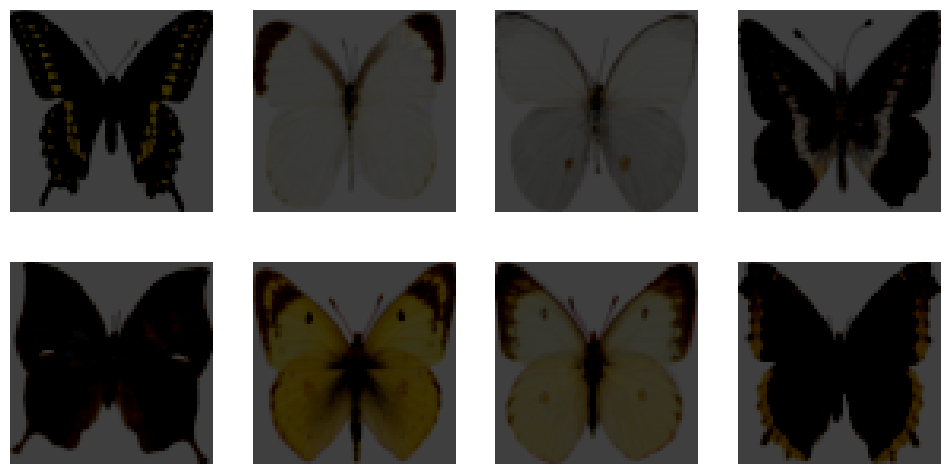

In [16]:
# let's load a batch and inspecting the images
batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for display
show_images((batch["images"][:8] * 0.5 * 0.5).clip(0, 1))

### Add Noise

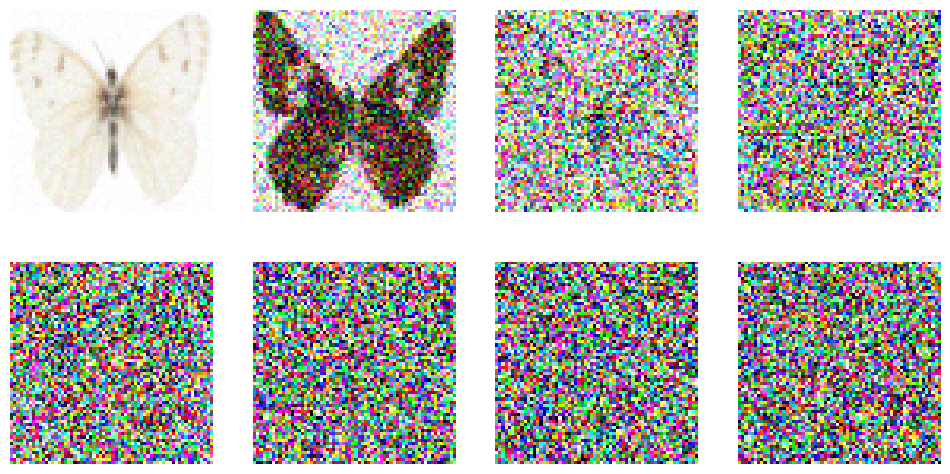

In [15]:
# adding noise is handled by a class called a Scheduler
scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.001,
    beta_end=0.02,
)

# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and add increasing amounts of noise to them
x = batch["images"][:8]
noise = torch.randn_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images((noised_x * 0.5 + 0.5).clip(0, 1))

###The UNet